In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Set options
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

# Load necessary libraries
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sudee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sudee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sudee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sudee\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [33]:

# Read CSV files
script1 = pd.read_csv("dialogues.csv", sep=",")
script2 = pd.read_csv("Harry Potter 2.csv", sep=";")
script3 = pd.read_csv("Harry Potter 3.csv", sep=";")

script1 = script1.rename(columns={'Speaker': 'Character'})
script1 = script1.rename(columns={'Dialogue': 'Sentence'})
# Rename columns
script3.columns = ["Character", "Sentence"]

# Trim whitespace from character names
script1["Character"] = script1["Character"].str.strip()
script2["Character"] = script2["Character"].str.strip()
script3["Character"] = script3["Character"].str.strip()

# Add 'Part' column
script1["Part"] = "Sorcerer's Stone"
script2["Part"] = "Chamber of Secrets"
script3["Part"] = "Prisoner of Azkaban"
# Concatenate dataframes
script = pd.concat([script1, script2, script3])

# Convert 'Part' column to categorical
script["Part"] = pd.Categorical(script["Part"], categories=["Prisoner of Azkaban", "Chamber of Secrets", "Sorcerer's Stone"])

# Standardize character names
def standardize_names(character):
    character = character.title()
    if character in ["Dumbledore"]:
        return "Dumbledore"
    elif character in ["Mcgonagall"]:
        return "McGonagall"
    elif character in ["Hagrid"]:
        return "Hagrid"
    # Add more name standardizations as needed
    else:
        return character

script["Character"] = script["Character"].apply(standardize_names)

In [34]:

# Fill NaN values in 'Sentence' column with an empty string
script['Sentence'].fillna("", inplace=True)

# Create a list of English stopwords
stop_words = set(stopwords.words('english'))

# Initialize Stemmer and Lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess text
def preprocess_text(text, use_lemmatization=False):
    if isinstance(text, str):  # Check if text is a string
        # Convert text to lowercase
        text = text.lower()
        # Remove numbers
        text = ''.join([i for i in text if not i.isdigit()])
        # Tokenize text
        tokens = word_tokenize(text)
        # Remove stopwords and punctuation
        tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
        # Apply Stemming or Lemmatization
        if use_lemmatization:
            tokens = [lemmatizer.lemmatize(word) for word in tokens]
        else:
            tokens = [stemmer.stem(word) for word in tokens]
        # Join tokens back into a string
        text = ' '.join(tokens)
        return text
    else:
        return ""  # Return empty string for non-string values (e.g., NaN)

# Apply text preprocessing with Stemming to each sentence in the dataframe
script['Sentence_Stemming'] = script['Sentence'].apply(lambda x: preprocess_text(x, use_lemmatization=False))

# Apply text preprocessing with Lemmatization to each sentence in the dataframe
script['Sentence_Lemmatization'] = script['Sentence'].apply(lambda x: preprocess_text(x, use_lemmatization=True))

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit and transform the data to create the term-document matrix
tdm = vectorizer.fit_transform(script['Sentence_Lemmatization'])

# Convert the term-document matrix to a DataFrame
tdm_df = pd.DataFrame(tdm.toarray(), columns=vectorizer.get_feature_names_out())

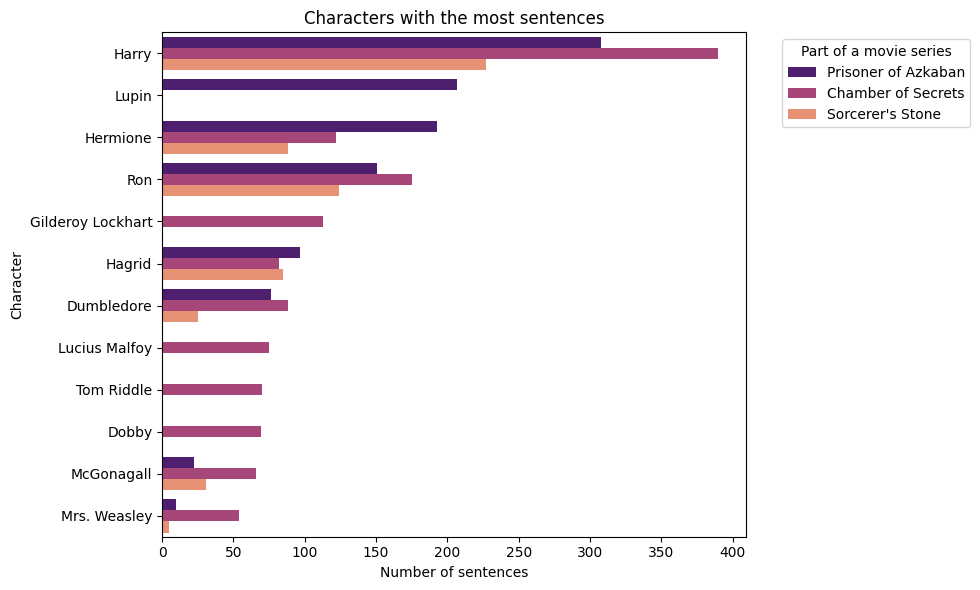

In [35]:


# Assuming Script is your DataFrame containing Character and Part columns

# Creating Char_Dial DataFrame
Char_Dial = pd.DataFrame(script.groupby(['Character', 'Part']).size()).reset_index()
Char_Dial.columns = ['Var1', 'Var2', 'Freq']

# Filtering and arranging data
filtered_data = Char_Dial[Char_Dial['Var1'].isin(["Harry", "Ron", "Hermione", "Hagrid", "Dumbledore", "Lupin", "McGonagall", "Draco Malfoy", "Gilderoy Lockhart",
                     "Severus Snape", "Lucius Malfoy", "Mrs. Weasley", "Tom Riddle", "Sirius Black", "Dobby"])].sort_values(by='Freq', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Freq', y='Var1', hue='Var2', data=filtered_data, palette='magma')
plt.xlabel('Number of sentences')
plt.ylabel('Character')
plt.title('Characters with the most sentences')
plt.legend(title='Part of a movie series', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

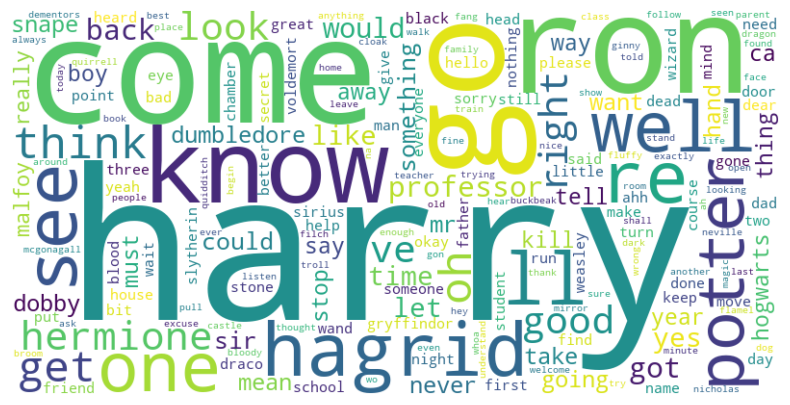

In [36]:


# Assuming tdm is your sparse matrix containing Word and Number columns

# Convert sparse matrix to DataFrame
tdm_df = pd.DataFrame(tdm.toarray(), columns=vectorizer.get_feature_names_out())
# Sum the frequencies of each word across all documents
word_freq = tdm_df.sum()

# Filter words with frequency greater than 8
filtered_words = word_freq[word_freq > 8]

# Create a dictionary from filtered words
word_freq_dict = filtered_words.to_dict()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [37]:
# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Assuming you have loaded your data into a DataFrame called 'script'

# Tokenization
script['word'] = script['Sentence_Lemmatization'].str.split()
script = script.explode('word')

# Classify words into neutral, positive, and negative
def classify_sentiment(word):
    if pd.isnull(word):
        return 'Neutral', 0.0
    else:
        score = sia.polarity_scores(word)['compound']
        if score > 0:
            return 'Positive', score
        elif score < 0:
            return 'Negative', score
        else:
            return 'Neutral', score

# Apply sentiment classification
script[['sentiment_class', 'polarity_score']] = script['word'].apply(lambda x: pd.Series(classify_sentiment(x)))

# Grouping and summarizing
Sentiment_summary = script.groupby(['word', 'sentiment_class']).size().reset_index(name='count')
Sentiment_summary = Sentiment_summary.sort_values(by='count', ascending=False).head(20)
script.head()


,Character,Sentence,Part,Sentence_Stemming,Sentence_Lemmatization,word,sentiment_class,polarity_score
0,Scene,,Sorcerer's Stone,,,NaN,Neutral,0.00
1,Dumbledore,I should have known that you would be here...P...,Sorcerer's Stone,known would ... professor mcgonagal,known would ... professor mcgonagall,known,Neutral,0.00
1,Dumbledore,I should have known that you would be here...P...,Sorcerer's Stone,known would ... professor mcgonagal,known would ... professor mcgonagall,would,Neutral,0.00
1,Dumbledore,I should have known that you would be here...P...,Sorcerer's Stone,known would ... professor mcgonagal,known would ... professor mcgonagall,...,Neutral,0.00
1,Dumbledore,I should have known that you would be here...P...,Sorcerer's Stone,known would ... professor mcgonagal,known would ... professor mcgonagall,professor,Neutral,0.00


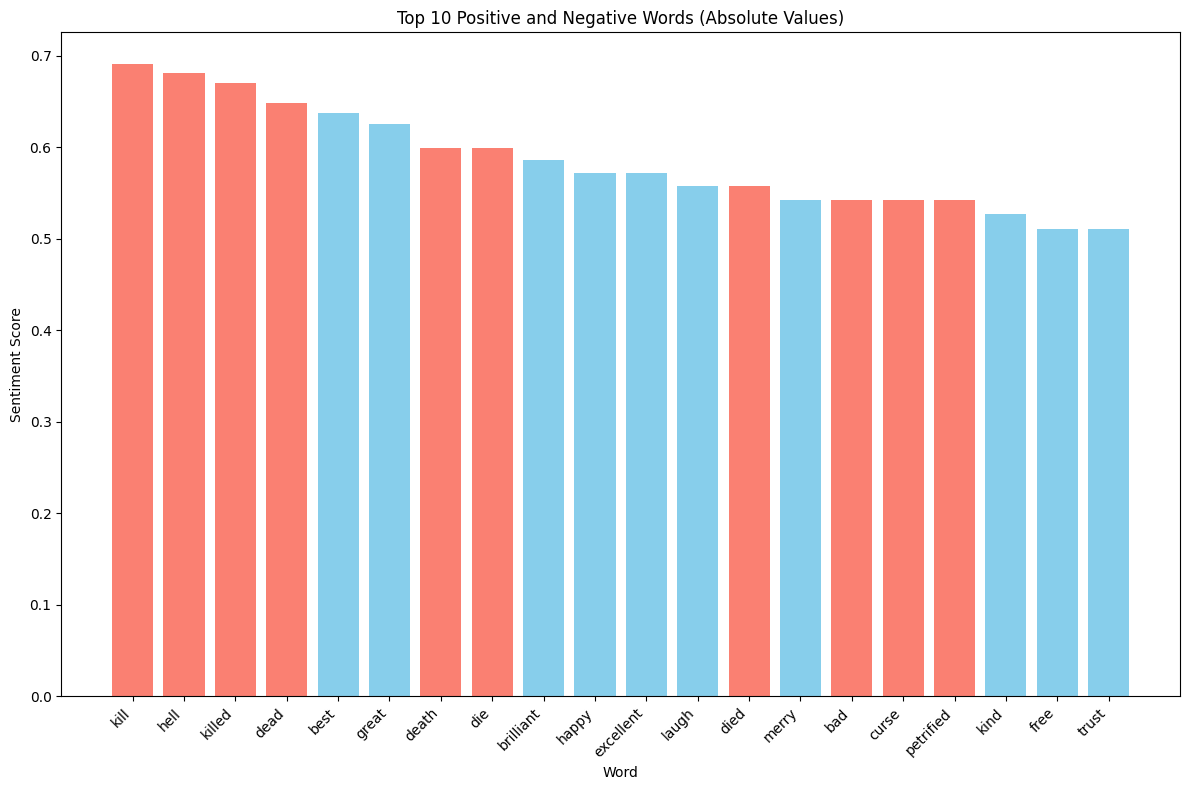

In [38]:


# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment score for each word
def calculate_sentiment(word):
    sentiment_score = sia.polarity_scores(word)['compound']
    return sentiment_score

# Apply sentiment analysis to each word in the WordCloud
word_sentiment = {word: calculate_sentiment(word) for word in word_freq_dict.keys()}

# Filter words with sentiment score greater than a threshold (e.g., 0.5 for positive sentiment)
# Filter words with sentiment score greater than a threshold (e.g., 0.5 for positive sentiment)
positive_words = {word: score for word, score in word_sentiment.items() if score > 0.5}

# Convert positive words to DataFrame for easier plotting
positive_df = pd.DataFrame.from_dict(positive_words, orient='index', columns=['SentimentScore'])

# Sort positive words by sentiment score
positive_df = positive_df.sort_values(by='SentimentScore', ascending=False)

# Filter words with sentiment score less than a threshold (e.g., -0.5 for negative sentiment)
negative_words = {word: score for word, score in word_sentiment.items() if score < -0.5}

# Convert negative words to DataFrame for easier plotting
negative_df = pd.DataFrame.from_dict(negative_words, orient='index', columns=['SentimentScore'])

# Sort negative words by sentiment score
negative_df = negative_df.sort_values(by='SentimentScore', ascending=True)
# Combine positive and negative words into a single DataFrame
combined_df = pd.concat([positive_df.head(10), negative_df.head(10)])

# Sort the combined DataFrame by sentiment score
combined_df['SentimentScoreAbs'] = np.abs(combined_df['SentimentScore'])

# Sort the DataFrame by absolute sentiment score
# Take the absolute value of sentiment scores
combined_df = combined_df.sort_values(by='SentimentScoreAbs', ascending=False)

# Plot the bar plot for combined positive and negative words with all values as positive
plt.figure(figsize=(12, 8))
colors = ['skyblue' if x > 0 else 'salmon' for x in combined_df['SentimentScore']]
plt.bar(combined_df.index, combined_df['SentimentScoreAbs'], color=colors)
plt.xlabel('Word')
plt.ylabel('Sentiment Score')
plt.title('Top 10 Positive and Negative Words (Absolute Values)')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)  # Add a horizontal line at y=0
plt.tight_layout()
plt.show()

In [39]:
print(negative_words)
print(positive_words)

{'bad': -0.5423, 'curse': -0.5423, 'dead': -0.6486, 'death': -0.5994, 'die': -0.5994, 'died': -0.5574, 'hell': -0.6808, 'kill': -0.6908, 'killed': -0.6705, 'petrified': -0.5423}
{'best': 0.6369, 'brilliant': 0.5859, 'excellent': 0.5719, 'free': 0.5106, 'great': 0.6249, 'happy': 0.5719, 'kind': 0.5267, 'laugh': 0.5574, 'merry': 0.5423, 'trust': 0.5106}


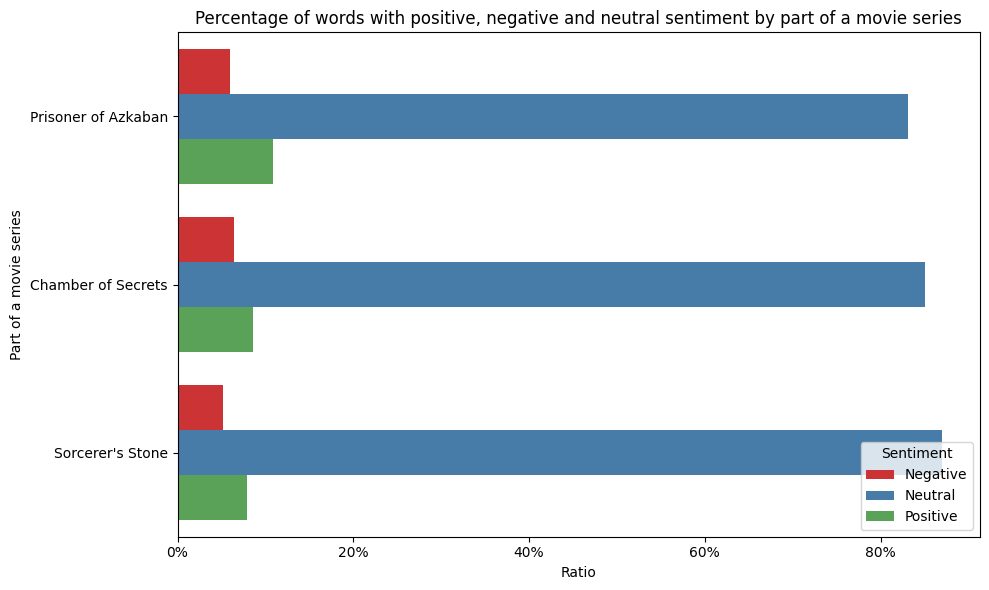

In [40]:

# Assuming you have a DataFrame called 'script' with 'Part' and 'sentiment_class' columns
# Group by 'Part' and 'sentiment_class', and calculate counts
sentiment_counts = script.groupby(['Part', 'sentiment_class']).size().reset_index(name='count')

total_counts = sentiment_counts.groupby('Part')['count'].sum().reset_index()

# Merge sentiment_counts with total_counts to calculate the ratio
sentiment_counts = sentiment_counts.merge(total_counts, on='Part', suffixes=('', '_total'))
sentiment_counts['ratio'] = sentiment_counts['count'] / sentiment_counts['count_total']

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_counts, x='ratio', y='Part', hue='sentiment_class', palette="Set1", orient='h')
plt.title('Percentage of words with positive, negative and neutral sentiment by part of a movie series')
plt.xlabel('Ratio')
plt.ylabel('Part of a movie series')
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])  # Convert x-axis labels to percentages
plt.legend(title='Sentiment', loc='lower right')
plt.tight_layout()
plt.show()

In [41]:



# Assuming 'script' is your DataFrame containing 'Sentence' and 'sentiment_class' columns
# Drop NaN values in 'Sentence' column
script = script.dropna(subset=['Sentence_Lemmatization'])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(script['Sentence_Lemmatization'], script['sentiment_class'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the classifier
svm_classifier.fit(X_train_tfidf, y_train)

# Predict on the test data
y_pred = svm_classifier.predict(X_test_tfidf)

# Print classification report with precision, recall, and F1-score
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

    Negative       0.26      0.02      0.04       211
     Neutral       0.86      0.99      0.92      3414
    Positive       0.62      0.10      0.17       362

    accuracy                           0.86      3987
   macro avg       0.58      0.37      0.38      3987
weighted avg       0.81      0.86      0.81      3987



In [53]:
def predict_sentiment(sentence):
    # Transform the new sentence using the same TF-IDF vectorizer
    X_new_tfidf = tfidf_vectorizer.transform([sentence])
    # Predict the sentiment
    prediction = svm_classifier.predict(X_new_tfidf)
    return prediction[0]  # Return the predicted sentiment

# Example usage:
new_sentence = "Go brilliant happy harry"
predicted_sentiment = predict_sentiment(new_sentence)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: Positive


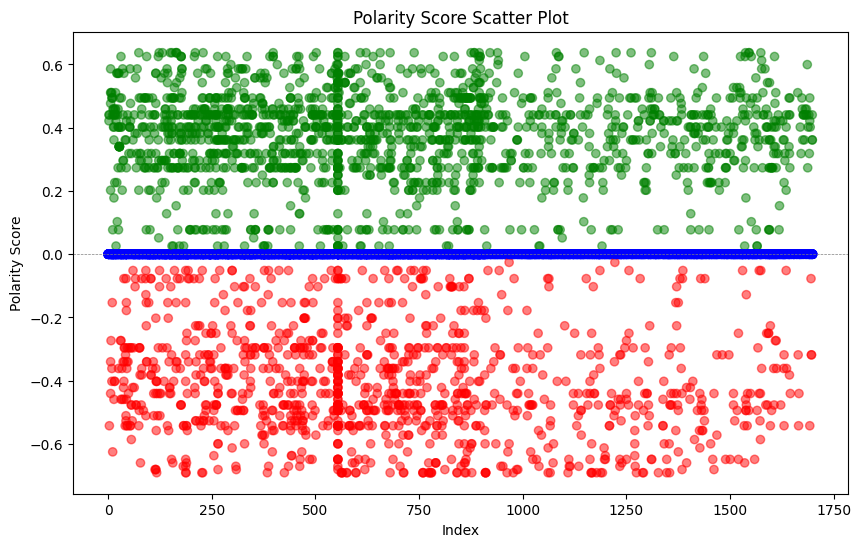

In [43]:
colors = ['red' if score < 0 else 'blue' if score == 0 else 'green' for score in script['polarity_score']]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(script.index, script['polarity_score'], c=colors, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Polarity Score')
plt.title('Polarity Score Scatter Plot')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)  # Add a horizontal line at y=0
plt.show()

In [44]:
# Top polarity scored dialogues
top_positive_dialogues = script.sort_values(by='polarity_score', ascending=False).drop_duplicates(subset=['Sentence']).head(3)

print("Top polarity scored dialogues:")
print(top_positive_dialogues[['Character', 'Sentence', 'Part', 'polarity_score']])

# Top negative polarity scored dialogues
top_negative_dialogues = script.sort_values(by='polarity_score').drop_duplicates(subset=['Sentence']).head(3)

print("\nTop negative polarity scored dialogues:")
print(top_negative_dialogues[['Character', 'Sentence', 'Part', 'polarity_score']])


Top polarity scored dialogues:
       Character                                           Sentence  \
1310       Harry  I didn't think my dad would have wanted his be...   
398          Ron  Oh, go on, Harry, Quidditch is great. Best gam...   
883   Dumbledore  Love, Harry, love. {Pats Harry's head and stan...   

                     Part  polarity_score  
1310  Prisoner of Azkaban            0.64  
398      Sorcerer's Stone            0.64  
883      Sorcerer's Stone            0.64  

Top negative polarity scored dialogues:
     Character                                           Sentence  \
228      Harry  Mr. Weasley why would I go looking for someone...   
1192     Lupin                               Very well. Kill him.   
1354     Harry                            They're gonna kill him?   

                     Part  polarity_score  
228   Prisoner of Azkaban           -0.69  
1192  Prisoner of Azkaban           -0.69  
1354  Prisoner of Azkaban           -0.69  


In [54]:
# Define the keyword you want to search for
keyword = input("Enter the keyword you want to search for: ")

# Initialize a count variable to keep track of occurrences
count = 0

# Initialize variables to store high polarity and low polarity sentences
max_polarity_score = float('-inf')  # Initialize to negative infinity
min_polarity_score = float('inf')   # Initialize to positive infinity
high_polarity_sentence = ""
low_polarity_sentence = ""

# Loop through each row in the script DataFrame
for index, row in script.iterrows():
    # Check if the word column contains the keyword
    if keyword == row["word"]:
        # If the word matches the keyword, increment the count
        count += 1
        # Check if the polarity score of the current sentence is higher than the max polarity score
        if row["polarity_score"] > max_polarity_score:
            max_polarity_score = row["polarity_score"]
            high_polarity_sentence = row["Sentence"]
        # Check if the polarity score of the current sentence is lower than the min polarity score
        elif row["polarity_score"] < min_polarity_score:
            min_polarity_score = row["polarity_score"]
            low_polarity_sentence = row["Sentence"]

# Print the result of keyword search
if count > 0:
    print("Yes, the keyword '{}' is present in the script. Count of occurrences: {}".format(keyword, count))
else:
    print("No, the keyword '{}' is not present in the script.".format(keyword))

# Print high polarity valued sentences
print("\nHigh polarity valued sentence:")
print(high_polarity_sentence)

# Print low polarity valued sentences
print("\nLow polarity valued sentence:")
print(low_polarity_sentence)



Yes, the keyword 'voldemort' is present in the script. Count of occurrences: 31

High polarity valued sentence:
No, I can't spell it. All right. His name was Voldemort.

Low polarity valued sentence:
Voldemort?
